Импорты

In [1]:
import pytorch_lightning as pl
from torch import nn
import torch
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm


CNN

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((64, 64)), 
                                transforms.Grayscale(num_output_channels=1)
                               ])

train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

mnist_train_dataset = ImageFolder(train_dir, transform=transform)
mnist_valid_dataset = ImageFolder(val_dir, transform=transform)
mnist_test_dataset = ImageFolder(test_dir, transform=transform)

# Размер батча
batch_size = 64

# Получение загрузчиков данных
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=False)

# Определение устройства (GPU или CPU)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Основной класс модели CNN
class PageClassificator(nn.Module):
    def __init__(self):
        super(PageClassificator, self).__init__()
        # Архитектура модели
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # self.flatten = nn.Flatten(start_dim=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16384, 1024)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        # Прямой проход данных через слои
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x) 
        # return x

    def train_model(self, num_epochs, train_dl, valid_dl):
        loss_fn = nn.CrossEntropyLoss()
        # loss_fn = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        
        loss_hist_train = []
        accuracy_hist_train = []
        loss_hist_valid = []
        accuracy_hist_valid = []
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")  # Сообщаем начало очередной эпохи
            
            # Прогрессбар для текущего этапа
            pbar_epoch = tqdm(total=len(train_dl), desc=f"Epoch {epoch+1} Training Progress", unit="batch")
            
            self.train()
            running_loss_train = 0.0
            correct_train = 0
            total_train = 0
            
            for x_batch, y_batch in train_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = self.forward(x_batch)
                
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                running_loss_train += loss.item() * y_batch.size(0)
                _, predicted = torch.max(pred.data, 1)
                total_train += y_batch.size(0)
                correct_train += (predicted == y_batch).sum().item()
                
                pbar_epoch.update()  # Обновляем прогрессбар на каждом батче
            
            pbar_epoch.close()  # Закрываем прогрессбар по окончании эпохи
            
            avg_loss_train = running_loss_train / total_train
            acc_train = correct_train / total_train
            loss_hist_train.append(avg_loss_train)
            accuracy_hist_train.append(acc_train)
            
            # Оценка на валидационном наборе
            self.eval()
            running_loss_valid = 0.0
            correct_valid = 0
            total_valid = 0
            
            with torch.no_grad():
                for x_batch, y_batch in valid_dl:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    
                    pred = self.forward(x_batch)
                    loss = loss_fn(pred, y_batch)
                    
                    running_loss_valid += loss.item() * y_batch.size(0)
                    _, predicted = torch.max(pred.data, 1)
                    total_valid += y_batch.size(0)
                    correct_valid += (predicted == y_batch).sum().item()
            
            avg_loss_valid = running_loss_valid / total_valid
            acc_valid = correct_valid / total_valid
            loss_hist_valid.append(avg_loss_valid)
            accuracy_hist_valid.append(acc_valid)
            
            print(f'Train Loss={avg_loss_train:.4f}, Train Acc={acc_train*100:.2f}% | '
                  f'Valid Loss={avg_loss_valid:.4f}, Valid Acc={acc_valid*100:.2f}%')
        
        return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

# Основная логика скрипта
if __name__ == '__main__':
    # Инициализация модели
    model = PageClassificator().to(device)
    print(model)
    
    
    # Настройки обучения
    torch.manual_seed(1)
    num_epochs = 100
    
    # Запуск процесса обучения
    hist = model.train_model(num_epochs, train_dl, valid_dl)

PageClassificator(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


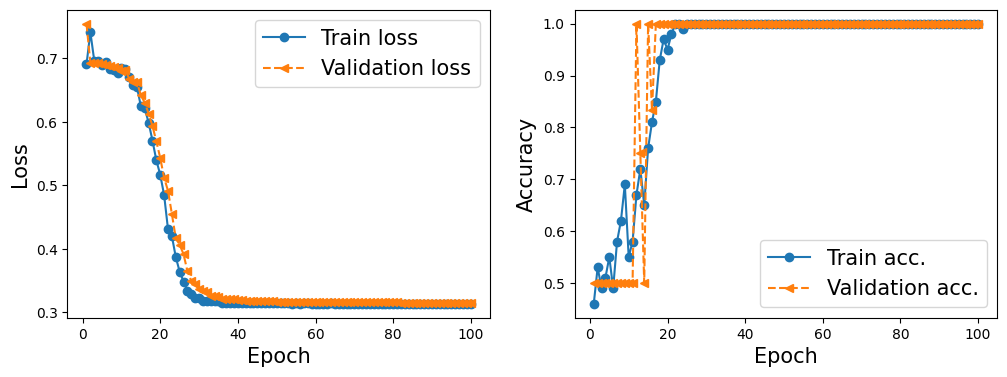

In [87]:
import matplotlib.pyplot as plt
import numpy as np


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [101]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        print(is_correct)
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_dl.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Test accuracy: 0.0000


tensor([[72.8751, 27.1249],
        [72.8529, 27.1471],
        [72.8065, 27.1935],
        [72.0348, 27.9652],
        [73.0559, 26.9441],
        [72.8547, 27.1453],
        [73.0896, 26.9104],
        [73.0469, 26.9531],
        [73.0604, 26.9396],
        [73.0784, 26.9216],
        [73.0795, 26.9205],
        [73.0582, 26.9418],
        [73.0345, 26.9655],
        [26.9959, 73.0041],
        [26.9308, 73.0692],
        [26.9789, 73.0211],
        [26.9303, 73.0697],
        [26.9365, 73.0635],
        [26.9328, 73.0672],
        [27.1646, 72.8354],
        [27.0556, 72.9444],
        [27.9717, 72.0283],
        [27.2222, 72.7778],
        [27.0087, 72.9913],
        [26.9902, 73.0098],
        [27.0351, 72.9649]])


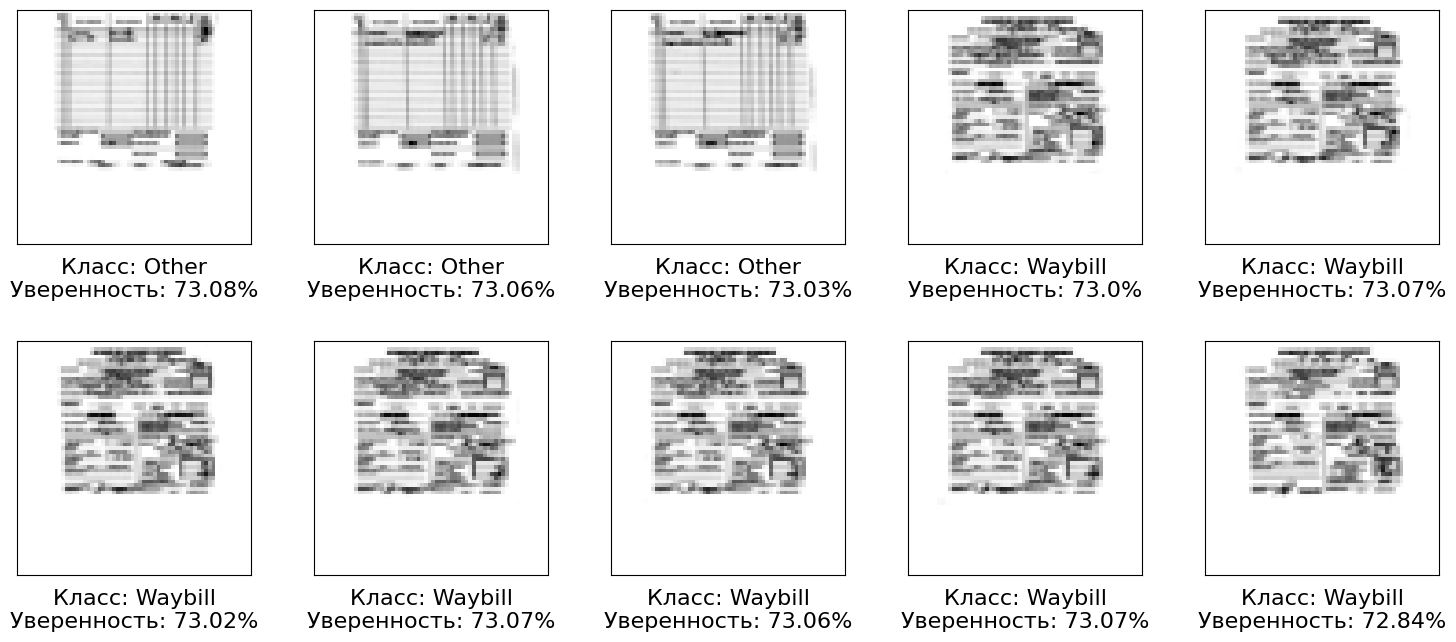

In [100]:
import torch.nn.functional as F

# Получаем предсказания модели
with torch.no_grad():
    pred_logits = model(x_batch)
    # Рассчитываем вероятности обоих классов с помощью softmax
    pred_probs = F.softmax(pred_logits, dim=1) * 100  # Умножаем на 100 для процентов
    print(pred_probs)

# Отображение результатов
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0), cmap="gray")  # Перестановка каналов для imshow
    true_label = int(y_batch[j])
    
    # Определяем метку и получаем соответствующую ей вероятность
    if true_label == 1:
        label = 'Waybill'
        class_prob = pred_probs[j][true_label]
    else:
        label = 'Other'
        class_prob = pred_probs[j][true_label]
    
    # Преобразуем в строку с точностью до двух десятичных знаков
    prob_class = round(class_prob.item(), 2)
    ax.text(
        0.5, -0.15, 
        f'Класс: {label}\nУверенность: {prob_class}%', 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)

plt.tight_layout()
plt.show()

Сохранение модели

In [89]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/waybill_validation_1.ph'
torch.save(model, path)

In [90]:
model = torch.load('models/waybill_validation_1.ph',
                  map_location=torch.device("cpu"),
                  weights_only=False,
                  ) 

Использование модели

In [103]:
import torch
from PIL import Image
from torchvision import transforms

# img_path = 'W_1.png'
img_path = 'O_2.png'

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((64, 64)), 
                                transforms.Grayscale(num_output_channels=1)
                               ])


# Открываем изображение и применяем преобразования
img = Image.open(img_path)
input_tensor = transform(img).unsqueeze(0)  # Добавляем размер партии (batch dimension)

with torch.no_grad():  # Отключаем градиенты для ускоренной обработки
    input_tensor = input_tensor.to(torch.device("cpu"))
    output = model(input_tensor)

labels = ['Other','Waybill']

# Получение класса с наибольшей вероятностью
print(output)
predicted_class = torch.argmax(output, dim=1)[0].item()
print(f"Предсказанный класс: {labels[predicted_class]}")

tensor([[0.9735, 0.0274]])
Предсказанный класс: Other
